By now basically everyone ([here](http://datacolada.org/2014/06/04/23-ceiling-effects-and-replications/?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+DataColada+%28Data+Colada+Feed%29), [here](http://yorl.tumblr.com/post/87428392426/ceiling-effects), [here](http://www.talyarkoni.org/blog/2014/06/01/there-is-no-ceiling-effect-in-johnson-cheung-donnellan-2014/), [here](http://pigee.wordpress.com/2014/05/24/additional-reflections-on-ceiling-effects-in-recent-replication-research/) and [here](http://www.nicebread.de/reanalyzing-the-schnalljohnson-cleanliness-data-sets-new-insights-from-bayesian-and-robust-approaches/), and there is likely even more out there) who writes a blog and knows how to do a statistical analysis has analysed data from a recent replication study and from the original study (data repository is here). 

The study of two experiments. Let's focus on Experiment 1 here. The experiment consists of a treatment and control group. The performance is measured by six likert-scale items. The scale has 9 levels. All responses are averaged together and we obtain a single composite score for each group. We are interested whether the treatment works, which would show up as a positive difference between the score of the treatment and the control group. Replication study did the same with more subjects.

Let's perform the original analysis to see the results and why this dataset is so "popular".

In [1]:
%pylab inline
import pystan
from matustools.matusplotlib import *
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
il=['dog','trolley','wallet','plane','resume','kitten','mean score','median score']
D=np.loadtxt('schnallstudy1.csv',delimiter=',')
D[:,1]=1-D[:,1]
Dtemp=np.zeros((D.shape[0],D.shape[1]+1))
Dtemp[:,:-1]=D
Dtemp[:,-1]=np.median(D[:,2:-2],axis=1)
D=Dtemp
DS=D[D[:,0]==0,1:]
DR=D[D[:,0]==1,1:]
DS.shape

(40, 9)

/usr/local/lib/python2.7/dist-packages/matplotlib-1.3.1-py2.7-linux-i686.egg/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib-1.3.1-py2.7-linux-i686.egg/matplotlib/figure.py:1595: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


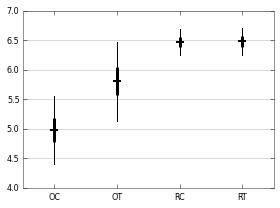

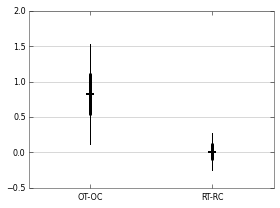

In [3]:
def plotCIttest1(y,x=0,alpha=0.05):
    m=y.mean();df=y.size-1
    se=y.std()/y.size**0.5
    cil=stats.t.ppf(alpha/2.,df)*se
    cii=stats.t.ppf(0.25,df)*se
    out=[m,m-cil,m+cil,m-cii,m+cii]
    _errorbar(out,x=x,clr='k')
    return out
    
def plotCIttest2(y1,y2,x=0,alpha=0.05):
    n1=float(y1.size);n2=float(y2.size);
    v1=y1.var();v2=y2.var()
    m=y2.mean()-y1.mean()
    s12=(((n1-1)*v1+(n2-1)*v2)/(n1+n2-2))**0.5
    se=s12*(1/n1+1/n2)**0.5
    df= (v1/n1+v2/n2)**2 / ( (v1/n1)**2/(n1-1)+(v2/n2)**2/(n2-1)) 
    cil=stats.t.ppf(alpha/2.,df)*se
    cii=stats.t.ppf(0.25,df)*se
    out=[m,m-cil,m+cil,m-cii,m+cii]
    _errorbar(out,x=x)
    return out

plt.figure(figsize=(4,3))
dts=[DS[DS[:,0]==0,-2],DS[DS[:,0]==1,-2],
     DR[DR[:,0]==0,-2],DR[DR[:,0]==1,-2]]
for k in range(len(dts)):
    plotCIttest1(dts[k],x=k)
plt.grid(False,axis='x')
ax=plt.gca()
ax.set_xticks(range(len(dts)))
ax.set_xticklabels(['OC','OT','RC','RT'])
plt.xlim([-0.5,len(dts)-0.5])
plt.figure(figsize=(4,3))
plotCIttest2(dts[0],dts[1],x=0,alpha=0.1)
plotCIttest2(dts[2],dts[3],x=1,alpha=0.1)
ax=plt.gca()
ax.set_xticks([0,1])
ax.set_xticklabels(['OT-OC','RT-RC'])
plt.grid(False,axis='x')
plt.xlim([-0.5,1.5]);

Legend: OC - original study, control group; OT - original study, treatment group; RC - replication study, control group; RT - replication study, treatment group; 

In the original study the difference between the treatment and control is significantly greater than zero. In the replication, it is not. However the ratings in the replication are higher overall. The author of the original study therefore raised a concern that no difference was obtained in replication because of ceiling effects. 

How do we show that there are ceiling efects in the replication? The authors and bloggers presented various arguments that support some conclusion (mostly that there are no ceiling effects). Ultimately ceiling effects are a matter of degree and since no one knows how to quantify them the whole discussion of the replication's validity is heading into an inferential limbo. 

My point here is that if the analysis computed the proper effect size - the causal effect size, we would avoid these kinds of arguments and discussions.

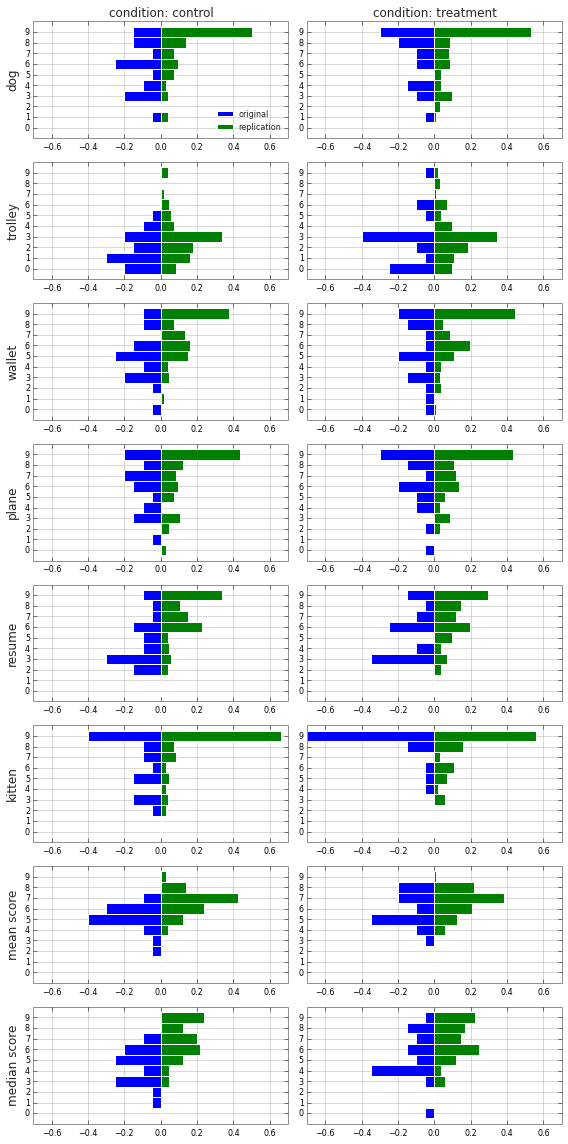

In [4]:
def plotComparison(A,B,stan=False):
    plt.figure(figsize=(8,16))
    cl=['control','treatment']
    x=np.arange(11)-0.5
    if not stan:assert A.shape[1]==B.shape[1]
    for i in range(A.shape[1]-1):
        for cond in range(2):
            plt.subplot(A.shape[1]-1,2,2*i+cond+1)
            a=np.histogram(A[A[:,0]==cond,1+i],bins=x, normed=True)
            plt.barh(x[:-1],-a[0],ec='w',height=1)
            if stan: a=[B[:,i,cond]]
            else: a=np.histogram(B[B[:,0]==cond,1+i],bins=x, normed=True)
            plt.barh(x[:-1],a[0],ec='w',fc='g',height=1)
            #plt.hist(DS[:,2+i],bins=np.arange(11)-0.5,normed=True,rwidth=0.5)
            plt.xlim([-0.7,0.7]);plt.gca().set_yticks(range(10))
            plt.ylim([-1,10]);#plt.grid(b=False,axis='y')
            if not i: plt.title('condition: '+cl[cond])
            if not cond: plt.ylabel(il[i],size=12)
            if not i and not cond: plt.legend(['original','replication'],loc=4);
plotComparison(DS,DR)

In [116]:
model='''
data {
    int<lower=2> K;
    int<lower=0> N;
    int<lower=1> M;
    int<lower=1,upper=K> y[N,M];
    int x[N];
}
parameters {
    real beta[M];
    ordered[K-1] c[M];
}
transformed parameters{
    real pt[M,K-1]; real pc[M,K-1];
    for (m in 1:M){
    for (k in 1:(K-1)){
        pt[m,k] <- inv_logit(beta[m]-c[m][k]);
        pc[m,k] <- inv_logit(-c[m][k]);
}}}
model {
for (m in 1:M){
    for (k in 1:(K-1)) c[m][k]~ uniform(-100,100);
    for (n in 1:N) y[n,m] ~ ordered_logistic(x[n] * beta[m], c[m]);
}}
'''
sm1=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0377c9bb8f1b5b3a8a8d14511c81c630 NOW.


In [117]:
dat = {'y':np.int32(DS[:,1:7])+1,'x':np.int32(DS[:,0]),'N':DS.shape[0] ,'K':10,'M':6}
fit = sm1.sampling(data=dat,iter=1000, chains=4,thin=2,warmup=500,njobs=2,seed=4)
print fit

Inference for Stan model: anon_model_0377c9bb8f1b5b3a8a8d14511c81c630.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

        mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta[0]  0.9     0.1  0.6 -0.3  0.5  0.8  1.3   2.1 124.0  1.0
beta[1]  0.7     0.0  0.5 -0.3  0.3  0.7  1.1   1.9 151.0  1.0
beta[2]  0.4     0.1  0.6 -0.7 -0.0  0.4  0.8   1.5 133.0  1.0
beta[3]  0.4     0.1  0.6 -0.9  0.0  0.4  0.8   1.6  99.0  1.0
beta[4]  0.8     0.1  0.6 -0.4  0.4  0.8  1.2   2.0 128.0  1.0
beta[5]  1.6     0.1  0.7  0.2  1.1  1.6  2.1   2.9 145.0  1.0
c[0,0] -54.7     3.0 26.8-96.2-79.8-54.2-33.5  -7.4  79.0  1.0
c[1,0]  -1.1     0.0  0.5 -2.1 -1.4 -1.1 -0.8  -0.2 117.0  1.0
c[2,0]  -3.6     0.1  0.9 -6.1 -4.1 -3.6 -3.0  -2.1  80.0  1.0
c[3,0]  -5.2     0.2  1.5 -8.9 -6.1 -5.1 -4.2  -2.9  82.0  1.0
c[4,0] -69.3     2.4 21.9-99.1-88.7-72.7-52.1 -24.4  84.0  1.0
c[5,0] -69.9     2.7 21.2-98.9-87.4-73.0-55.3 -23.3  61.0

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


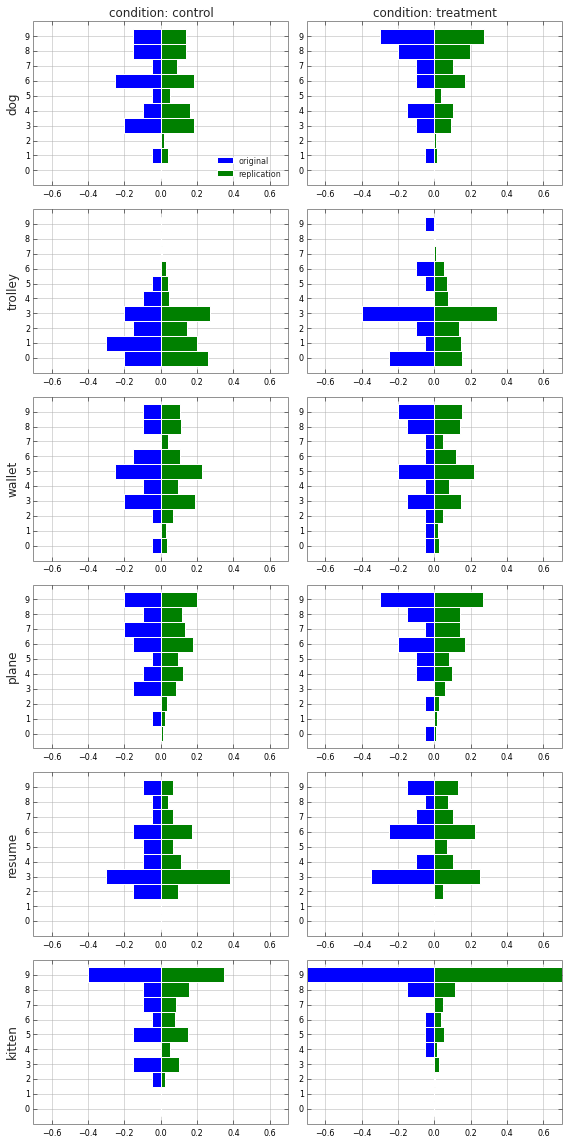

In [118]:
pt=fit.extract()['pt']
pc=fit.extract()['pc']
DP=np.zeros((pt.shape[2]+2,pt.shape[1],2))
DP[0,:,:]=1
DP[1:-1,:,:]=np.array([pc,pt]).T.mean(2)
DP=-np.diff(DP,axis=0)
plotComparison(DS[:,:7],DP,stan=True)

In [5]:
model='''
data {
    int<lower=2> K;
    int<lower=0> N;
    int<lower=1> M;
    int<lower=1,upper=K> y[N,M];
    int x[N];
}
parameters {
    real beta;
    ordered[K-1] c[M];
}
transformed parameters{
    real pt[M,K-1]; real pc[M,K-1];
    for (m in 1:M){
    for (k in 1:(K-1)){
        pt[m,k] <- inv_logit(beta-c[m][k]);
        pc[m,k] <- inv_logit(-c[m][k]);
}}}
model {
for (m in 1:M){
    for (k in 1:(K-1)) c[m][k]~ uniform(-100,100);
    for (n in 1:N) y[n,m] ~ ordered_logistic(x[n] * beta, c[m]);
}}
'''
sm2=pystan.StanModel(model_code=model)

In [6]:
dat = {'y':np.int32(DS[:,1:7])+1,'x':np.int32(DS[:,0]),'N':DS.shape[0] ,'K':10,'M':6}
fit2 = sm2.sampling(data=dat,iter=1000, chains=4,thin=2,warmup=500,njobs=2,seed=4)
print fit2
saveStanFit(fit2,'fit2')

Inference for Stan model: anon_model_7216e04af35b427b9a410fdc88ae5601.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

        mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta     0.7     0.0  0.2  0.3  0.6  0.7  0.9   1.2 132.0  1.0
c[0,0] -53.7     4.2 26.8-97.1-75.8-55.2-31.5  -8.7  40.0  1.1
c[1,0]  -1.1     0.0  0.4 -1.8 -1.3 -1.1 -0.8  -0.4 103.0  1.0
c[2,0]  -3.6     0.1  1.0 -5.7 -4.2 -3.5 -2.9  -2.0  79.0  1.0
c[3,0]  -5.2     0.2  1.4 -8.5 -5.9 -4.9 -4.1  -3.0  75.0  1.0
c[4,0] -68.0     2.2 22.1-99.0-86.7-71.2-52.1 -21.5 106.0  1.0
c[5,0] -71.0     2.3 21.8-99.1-89.1-75.7-54.6 -23.0  88.0  1.0
c[0,1]  -3.5     0.1  0.9 -5.4 -4.1 -3.4 -2.9  -2.0 172.0  1.0
c[1,1]  -0.1     0.0  0.3 -0.8 -0.4 -0.1  0.1   0.5 152.0  1.0
c[2,1]  -2.7     0.1  0.7 -4.2 -3.1 -2.7 -2.2  -1.5 117.0  1.0
c[3,1]  -3.7     0.1  1.1 -6.8 -4.1 -3.5 -3.0  -2.1  64.0  1.1
c[4,1] -36.2     2.0 21.4-81.5-51.8-33.3-18.3  -5.3 114.0

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


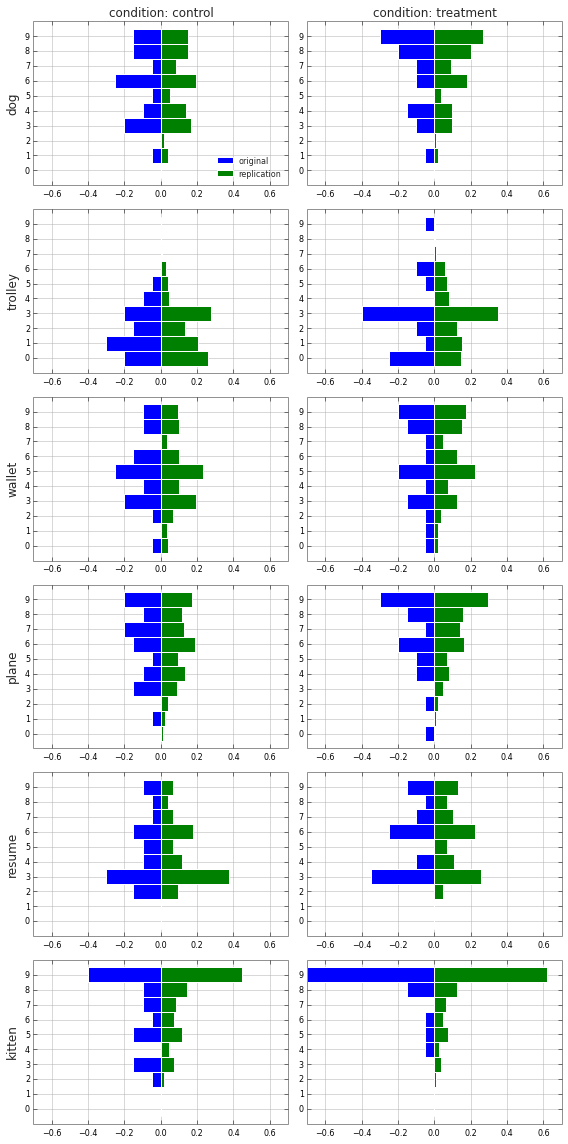

In [14]:
w=loadStanFit('fit2')
pt=w['pt']
pc=w['pc']
DP=np.zeros((pt.shape[2]+2,pt.shape[1],2))
DP[0,:,:]=1
DP[1:-1,:,:]=np.array([pc,pt]).T.mean(2)
DP=-np.diff(DP,axis=0)
plotComparison(DS[:,:7],DP,stan=True)

In [31]:
model='''
data {
    int<lower=2> K;
    int<lower=0> N;
    int<lower=1> M;
    int<lower=1,upper=K> y[N,M];
    int x[N];
}
parameters {
    // real mb; real<lower=0,upper=100> sb[2];
    vector[2*M-1] bbeta;
    ordered[K-1] c;
}
transformed parameters{
    real pt[M,K-1]; real pc[M,K-1];
    vector[M] beta[2];
    for (m in 1:M){
        if (m==1){beta[1][m]<-0.0; beta[2][m]<-bbeta[2*M-1];}
        else{beta[1][m]<-bbeta[2*(m-1)-1]; beta[2][m]<-bbeta[2*(m-1)];}
    for (k in 1:(K-1)){
        pt[m,k] <- inv_logit(beta[2][m]-c[k]);
        pc[m,k] <- inv_logit(beta[1][m]-c[k]);
}}}
model {
for (k in 1:(K-1)) c[k]~ uniform(-100,100);
//beta[1]~normal(0.0,sb[1]);
//beta[2]~normal(mb,sb[2]);
for (m in 1:M){
    for (n in 1:N) y[n,m] ~ ordered_logistic(beta[x[n]+1][m], c);
}}
'''
sm3=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b233c89bb9dd8a0b522a51670536ebd9 NOW.


In [32]:
dat = {'y':np.int32(DS[:,1:7])+1,'x':np.int32(DS[:,0]),'N':DS.shape[0] ,'K':10,'M':6}
fit3 = sm3.sampling(data=dat,iter=1000, chains=4,thin=2,warmup=500,njobs=2,seed=4)
#print fit3
saveStanFit(fit3,'fit3')

ZeroDivisionError: float division

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


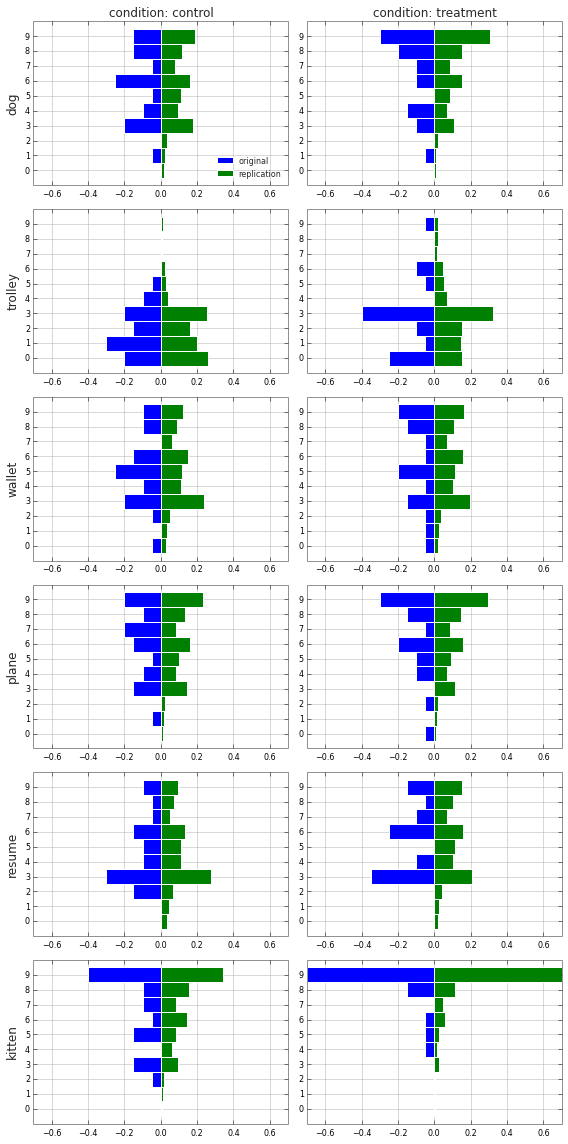

In [34]:
w=loadStanFit('fit3')
pt=w['pt']
pc=w['pc']
DP=np.zeros((pt.shape[2]+2,pt.shape[1],2))
DP[0,:,:]=1
DP[1:-1,:,:]=np.array([pc,pt]).T.mean(2)
DP=-np.diff(DP,axis=0)
plotComparison(DS[:,:7],DP,stan=True)

In [4]:
model='''
data {
    int<lower=2> K;
    int<lower=0> N;
    int<lower=1> M;
    int<lower=1,upper=K> y[N,M];
    int x[N];
}
parameters {
    // real mb; real<lower=0,upper=100> sb[2];
    vector[M-1] bbeta;
    real delt;
    ordered[K-1] c;
}
transformed parameters{
    real pt[M,K-1]; real pc[M,K-1];
    vector[M] beta;
    for (m in 1:M){
        if (m==1) beta[m]<-0.0; 
        else beta[m]<-bbeta[m-1];
    for (k in 1:(K-1)){
        pt[m,k] <- inv_logit(beta[m]+delt-c[k]);
        pc[m,k] <- inv_logit(beta[m]-c[k]);
}}}
model {
for (k in 1:(K-1)) c[k]~ uniform(-100,100);
for (m in 1:M){
    for (n in 1:N) y[n,m] ~ ordered_logistic(beta[m]+delt*x[n], c);
}}
'''
sm4=pystan.StanModel(model_code=model)

In [5]:
dat = {'y':np.int32(DS[:,1:7])+1,'x':np.int32(DS[:,0]),'N':DS.shape[0] ,'K':10,'M':6}
fit4 = sm4.sampling(data=dat,iter=1000, chains=4,thin=2,warmup=500,njobs=2,seed=4)
print pystan.misc._print_stanfit(fit4,pars=['delt','bbeta','c'],digits_summary=2)
saveStanFit(fit4,'fit4')

Inference for Stan model: anon_model_ea755999b4327833f97905399d8651f3.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
delt     0.67    0.01 0.24 0.21 0.51 0.67 0.83  1.14 334.0  1.0
bbeta[0]-3.16    0.03 0.46-4.04-3.47-3.16-2.85 -2.26 240.0  1.0
bbeta[1]-0.68    0.02  0.4-1.47-0.95-0.68-0.42  0.11 264.0  1.0
bbeta[2]  0.1    0.02  0.4-0.67-0.19 0.11 0.36  0.94 288.0  1.0
bbeta[3]-0.91    0.02  0.4-1.67-1.19-0.91-0.63 -0.14 260.0  1.0
bbeta[4] 1.24    0.02 0.41  0.4 0.97 1.24 1.51  2.02 302.0  1.0
c[0]    -4.22    0.03 0.46-5.14-4.53-4.22-3.92 -3.28 272.0  1.0
c[1]    -3.32    0.03 0.41-4.13 -3.6-3.34-3.02 -2.46 249.0  1.0
c[2]    -2.65    0.02 0.39-3.37-2.91-2.66-2.39 -1.85 269.0  1.0
c[3]    -1.16    0.02 0.33-1.78-1.38-1.17-0.93 -0.51 256.0  1.0
c[4]    -0.68    0.02 0.32-1.28-0.89-0.68-0.47 -0.04 267.0  1.0
c[5]     -0.2    0.02 0.31-0.79-0.42-0.19-0.0

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


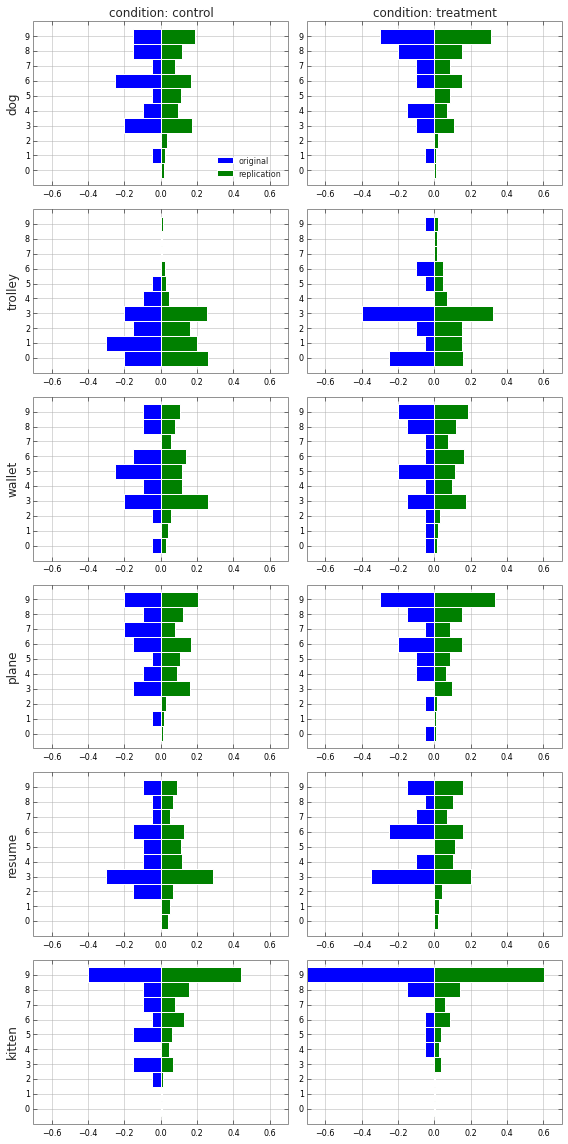

In [6]:
w=loadStanFit('fit4')
pt=w['pt']
pc=w['pc']
DP=np.zeros((pt.shape[2]+2,pt.shape[1],2))
DP[0,:,:]=1
DP[1:-1,:,:]=np.array([pc,pt]).T.mean(2)
DP=-np.diff(DP,axis=0)
plotComparison(DS[:,:7],DP,stan=True)

delt 0.673595459215 CI [0.211,1.140]


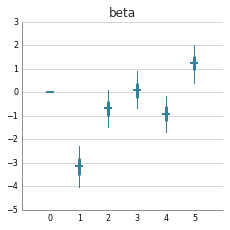

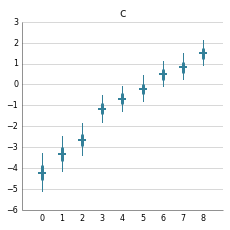

In [7]:
pystanErrorbar(w,keys=['beta','c','delt'])

In [9]:
dat = {'y':np.int32(DR[:,1:7])+1,'x':np.int32(DR[:,0]),'N':DR.shape[0] ,'K':10,'M':6}
fit5 = sm4.sampling(data=dat,iter=1000, chains=4,thin=2,warmup=500,njobs=2,seed=4)
print pystan.misc._print_stanfit(fit4,pars=['delt','bbeta','c'],digits_summary=2)
saveStanFit(fit5,'fit5')

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


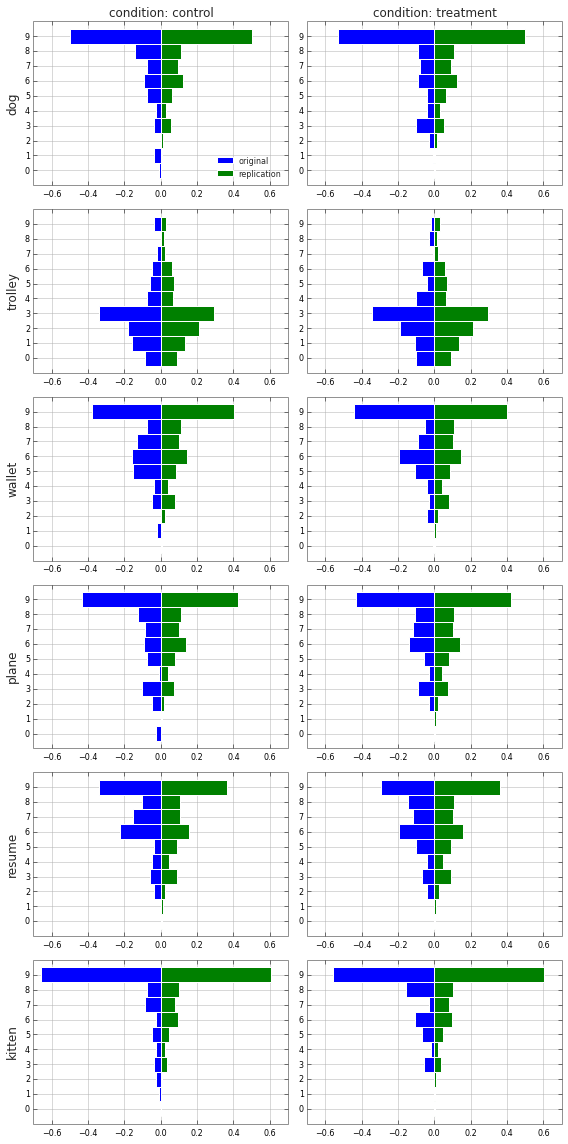

In [13]:
w=loadStanFit('fit5')
pt=w['pt']
pc=w['pc']
DP=np.zeros((pt.shape[2]+2,pt.shape[1],2))
DP[0,:,:]=1
DP[1:-1,:,:]=np.array([pc,pt]).T.mean(2)
DP=-np.diff(DP,axis=0)
plotComparison(DR[:,:7],DP,stan=True)

delt -0.0163305817326 CI [-0.220,0.186]


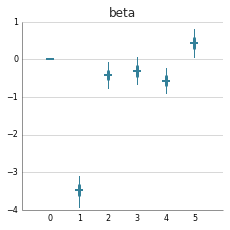

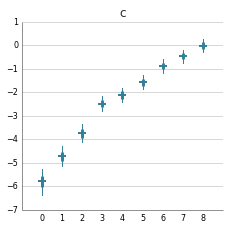

In [14]:
pystanErrorbar(w,keys=['beta','c','delt'])

In [18]:
model='''
data {
    int<lower=2> K;
    int<lower=0> N;
    int<lower=1> M;
    int<lower=1,upper=K> y[N,M];
    int x[N,2];
}
parameters {
    // real mb; real<lower=0,upper=100> sb[2];
    vector[M-1] bbeta;
    real dd[3];
    ordered[K-1] c;
}
transformed parameters{
    //real pt[M,K-1]; real pc[M,K-1];
    vector[M] beta;
    for (m in 1:M){
        if (m==1) beta[m]<-0.0; 
        else beta[m]<-bbeta[m-1];
    //for (k in 1:(K-1)){
    //    pt[m,k] <- inv_logit(beta[m]+delt-c[k]);
    //    pc[m,k] <- inv_logit(beta[m]-c[k]);}
}}
model {
for (k in 1:(K-1)) c[k]~ uniform(-100,100);
for (m in 1:M){
    for (n in 1:N) y[n,m] ~ ordered_logistic(beta[m]
        +dd[2]*x[n,1]*(1-x[n,2]) // rep + control
        +dd[1]*x[n,2]*(1-x[n,1]) // orig + treat
        +dd[3]*x[n,1]*x[n,2], c); // rep + treat
}}
'''
sm5=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5463f0c280d4ea208ffd631f059de31d NOW.


In [19]:
dat = {'y':np.int32(D[:,2:8])+1,'x':np.int32(D[:,[0,1]]),'N':D.shape[0] ,'K':10,'M':6}
fit6 = sm5.sampling(data=dat,iter=1000, chains=4,thin=2,warmup=500,njobs=2,seed=4)
print pystan.misc._print_stanfit(fit6,pars=['dd','bbeta','c'],digits_summary=2)
saveStanFit(fit6,'fit6')

Inference for Stan model: anon_model_5463f0c280d4ea208ffd631f059de31d.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
dd[0]    0.67    0.01 0.22 0.22 0.52 0.67 0.82  1.12 307.0  1.0
dd[1]    1.23    0.01 0.18 0.88 1.11 1.24 1.35  1.58 307.0  1.0
dd[2]    1.21    0.01 0.18 0.86 1.09 1.21 1.33  1.57 306.0  1.0
bbeta[0] -3.4    0.01 0.18-3.75-3.53-3.39-3.27 -3.06 317.0  1.0
bbeta[1]-0.44    0.01 0.16-0.75-0.56-0.43-0.33 -0.11 295.0  1.0
bbeta[2]-0.24    0.01 0.17-0.59-0.35-0.25-0.12  0.09 309.0  1.0
bbeta[3]-0.61    0.01 0.17-0.94-0.73-0.62-0.49 -0.28 296.0  1.0
bbeta[4] 0.57    0.01 0.18 0.23 0.45 0.56 0.69  0.92 293.0 1.01
c[0]    -4.42    0.02 0.27-4.94-4.61-4.43-4.23 -3.94 311.0  1.0
c[1]    -3.41    0.01 0.24-3.89-3.58-3.41-3.25 -2.95 314.0  1.0
c[2]    -2.52    0.01 0.22-2.95-2.67-2.52-2.37 -2.08 303.0  1.0
c[3]    -1.21    0.01 0.21 -1.6-1.35 -1.2-1.0

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


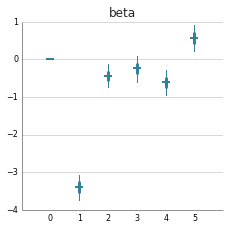

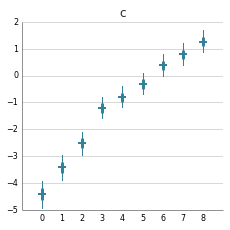

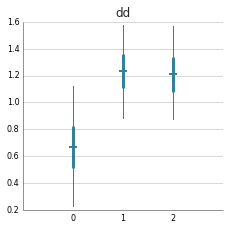

In [4]:
w=loadStanFit('fit6')
pystanErrorbar(w,keys=['beta','c','dd'])

var 0.670, CI 0.225, 1.119
var 1.233, CI 0.882, 1.575
var 1.213, CI 0.874, 1.566
var -0.020, CI -0.212, 0.180


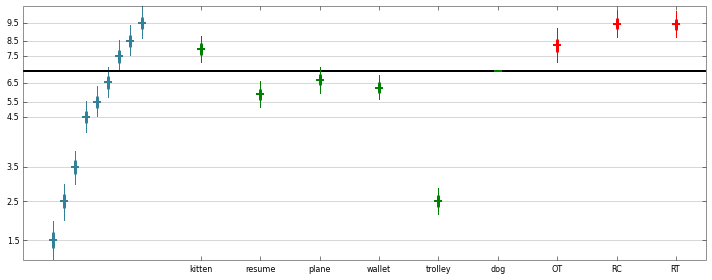

In [5]:
plt.figure(figsize=(10,4))
c=w['c']
b=w['beta']
d=w['dd']
errorbar(c,x=np.linspace(6.5,8,9))
ax=plt.gca()
plt.plot([-1,100],[0,0],'k',lw=2)
ax.set_yticks(np.median(c,axis=0))
ax.set_yticklabels(np.arange(1,10)+0.5)
plt.grid(b=False,axis='x')
errorbar(b[:,::-1],x=np.arange(9,15),clr='g')
errorbar(d,x=np.arange(15,18),clr='r')
plt.xlim([6,17.5])
ax.set_xticks(range(9,18))
ax.set_xticklabels(il[:6][::-1]+['OT','RC','RT'])
for i in range(d.shape[1]): printCI(d[:,i])
printCI(d[:,2]-d[:,1])

In [71]:

c

array([-4.43052332, -3.41268281, -2.51805659, -1.20427735, -0.82246801,
       -0.31043105,  0.38096304,  0.78885334,  1.2589707 ])

In [6]:
def ordinalLogitRvs(beta, c,n,size=1):
    assert np.all(np.diff(c)>0) # c must be strictly increasing
    def invLogit(x): return 1/(1+np.exp(-x))
    p=[1]+list(invLogit(beta-c))+[0]
    p=-np.diff(p)
    #return np.random.multinomial(n,p,size)
    return np.int32(np.round(p*n))
def reformatData(dat):
    out=[]
    for k in range(dat.size):
        out.extend([k]*dat[k])
    return np.array(out)
b=np.linspace(-10,7,21)
d=np.median(w['dd'][:,0])
c=np.median(w['c'],axis=0)
S=[];P=[]
for bb in b:
    S.append([np.squeeze(ordinalLogitRvs(bb,c,100)),
              np.squeeze(ordinalLogitRvs(bb+d,c,100))])
    P.append([reformatData(S[-1][0]),reformatData(S[-1][1])])

In [7]:
model='''
data {
    int<lower=2> K;
    int<lower=0> y1[K];
    int<lower=0> y2[K];
}
parameters {
    real<lower=-1000,upper=1000> d;
    ordered[K-1] c;
}
model {
for (k in 1:(K-1)) c[k]~ uniform(-200,200);
for (k in 1:K){
    for (n in 1:y1[k]) k~ ordered_logistic(0.0,c);
    for (n in 1:y2[k]) k~ ordered_logistic(d  ,c);
}}
'''
sm9=pystan.StanModel(model_code=model)

In [12]:
#(S[k][0]!=0).sum()+1
for k in range(21): 
    i1=np.nonzero(S[k][0]!=0)[0]
    i2=np.nonzero(S[k][1]!=0)[0]
    if max((S[k][0]!=0).sum(),(S[k][1]!=0).sum())<9:
        s= max(min(i1[0],i2[0])-1,0)
        e= min(max(i1[-1],i2[-1])+1,10)
        S[k][0]=S[k][0][s:e+1]
        S[k][1]=S[k][1][s:e+1]

In [14]:
S[0][0].size

2

In [15]:
ds=[];cs=[]
for k in range(len(S)):
    dat = {'y1':S[k][0],'y2':S[k][1],'K':S[k][0].size}
    fit = sm9.sampling(data=dat,iter=1000, chains=4,thin=2,warmup=500,njobs=2,seed=4)
    print fit
    saveStanFit(fit,'dc%d'%k)

Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d   -451.0    25.8311.4-970.4-714.4-435.7-200.2  77.5 146.0  1.0
c[0] 99.7     4.8 56.2  9.7 52.6100.1146.0 194.5 138.0  1.0
lp__  5.7     0.1  0.7  3.4  5.5  6.0  6.2   6.2 147.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 21:39:48 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d    -0.2     0.1  1.8 -4.2 -1.3 -0.1  1.0   3.3 155.0  1.0
c[0]  5.0     0.1  1.2  3.2  4.2  4.9  5.6   7.9 132.0  1.0
c[1] 98.9     4.5 55.0 15.3 53.7 93.6146.4 196.6 149.0  1.0
lp__ -1.9     0.1  1.5 -5.5 -2.6 -1.6 -0.8   0.1 143.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 21:40:11 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     1.5     0.1  1.3 -0.9  0.6  1.4  2.2   4.4 116.0  1.0
c[0]  5.1     0.1  1.2  3.3  4.3  4.9  5.8   7.8 113.0  1.0
c[1]  7.3     0.1  1.6  4.6  6.1  7.1  8.3  10.7 165.0  1.0
c[2]102.4     4.4 52.4 15.1 57.9100.8147.8 193.2 143.0  1.0
lp__-11.8     0.1  1.5-15.8-12.5-11.5-10.7  -9.7 181.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 21:41:09 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.5     0.1  0.6 -0.7  0.0  0.4  0.9   1.6  63.0  1.1
c[0]  2.9     0.1  0.5  2.0  2.6  3.0  3.3   3.9  36.0  1.1
c[1]  4.1     0.1  0.6  3.0  3.7  4.1  4.5   5.4  78.0  1.0
c[2]  5.5     0.1  0.9  3.9  4.9  5.4  6.0   7.4 127.0  1.0
c[3] 92.8    26.5 59.4  7.0 36.3 89.7144.0 196.2   5.0  1.3
lp__-51.4     0.5  2.0-56.5-52.3-51.0-50.0 -48.7  16.0  1.2

Samples were drawn using NUTS(diag_e) at Sat Jun 14 21:45:44 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.8     0.0  0.5 -0.1  0.4  0.8  1.1   1.7 136.0  1.0
c[0]  2.3     0.0  0.4  1.7  2.1  2.3  2.6   3.2 105.0  1.0
c[1]  3.6     0.0  0.5  2.8  3.3  3.6  3.9   4.6 101.0  1.0
c[2]  5.0     0.0  0.7  3.7  4.5  4.9  5.3   6.4 191.0  1.0
c[3] 99.6     5.0 54.0 11.3 54.0 95.8147.4 192.7 115.0  1.0
lp__-89.3     0.1  1.7-93.5-90.2-89.0-88.0 -86.8 166.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 21:47:01 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.1  0.5  0.8  1.0   1.4 184.0  1.0
c[0]  1.4     0.0  0.2  0.9  1.2  1.4  1.6   1.9 148.0  1.0
c[1]  2.4     0.0  0.3  1.8  2.2  2.4  2.6   3.1 112.0  1.0
c[2]  3.5     0.0  0.4  2.7  3.2  3.5  3.7   4.3 132.0  1.0
c[3]  5.5     0.1  0.8  4.1  4.9  5.4  6.0   7.2 165.0  1.0
c[4]  7.0     0.1  1.4  4.7  6.0  6.8  7.7  10.4 155.0  1.0
c[5]102.3     6.0 56.2 14.1 53.2 99.8152.4 195.0  89.0  1.0
lp__-165.5     0.2  2.0-170.0-166.7-165.2-164.0-162.3 134.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 21:48:58 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.1  0.5  0.7  0.8   1.2 105.0  1.0
c[0]  0.5     0.0  0.2  0.1  0.3  0.5  0.6   0.9  81.0  1.1
c[1]  1.5     0.0  0.2  1.1  1.4  1.5  1.7   2.0  89.0  1.0
c[2]  2.5     0.0  0.3  2.0  2.3  2.5  2.7   3.1 100.0  1.0
c[3]  4.2     0.1  0.5  3.3  3.8  4.2  4.6   5.3 111.0  1.0
c[4]  5.1     0.1  0.7  3.8  4.6  5.0  5.5   6.6  72.0  1.0
c[5]  6.9     0.1  1.4  4.9  5.9  6.7  7.6  10.6 107.0  1.0
c[6] 99.3     5.3 58.0 11.8 47.0 95.0148.6 196.5 120.0  1.0
lp__-239.1     0.1  2.0-243.5-240.4-239.0-237.6-235.8 172.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 21:51:08 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.8     0.0  0.3  0.3  0.6  0.7  0.9   1.3 334.0  1.0
c[0] -0.3     0.0  0.2 -0.7 -0.5 -0.3 -0.2   0.0 330.0  1.0
c[1]  0.7     0.0  0.2  0.3  0.6  0.7  0.8   1.1 334.0  1.0
c[2]  1.6     0.0  0.2  1.2  1.5  1.6  1.8   2.1 334.0  1.0
c[3]  3.0     0.0  0.3  2.4  2.8  3.0  3.2   3.6 308.0  1.0
c[4]  3.5     0.0  0.4  2.8  3.3  3.5  3.7   4.3 295.0  1.0
c[5]  4.2     0.0  0.5  3.3  3.8  4.1  4.5   5.2 320.0  1.0
c[6]  5.1     0.0  0.7  4.0  4.6  5.1  5.5   6.6 321.0  1.0
c[7]  6.0     0.0  0.9  4.5  5.4  5.9  6.5   7.8 333.0  1.0
c[8]  7.5     0.1  1.5  5.2  6.5  7.3  8.3  11.2 327.0  1.0
lp__-320.5     0.1  2.3-325.8-321.8-320.2-318.8-317.2 282.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 21:53:53 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.2  0.5  0.7  0.9   1.3 334.0  1.0
c[0] -1.2     0.0  0.2 -1.6 -1.4 -1.2 -1.1  -0.8 333.0  1.0
c[1] -0.2     0.0  0.2 -0.6 -0.3 -0.2 -0.1   0.2 329.0  1.0
c[2]  0.7     0.0  0.2  0.3  0.6  0.7  0.8   1.1 333.0  1.0
c[3]  2.0     0.0  0.2  1.6  1.9  2.0  2.1   2.5 334.0  1.0
c[4]  2.4     0.0  0.3  1.9  2.2  2.4  2.6   2.9 334.0  1.0
c[5]  3.0     0.0  0.3  2.4  2.8  2.9  3.2   3.6 324.0  1.0
c[6]  3.8     0.0  0.4  3.0  3.5  3.8  4.0   4.6 317.0  1.0
c[7]  4.4     0.0  0.5  3.5  4.1  4.4  4.8   5.5 321.0  1.0
c[8]  5.3     0.0  0.7  4.0  4.7  5.2  5.7   6.8 326.0  1.0
lp__-376.2     0.1  2.1-381.0-377.5-376.0-374.7-373.1 307.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 21:56:51 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.2  0.2  0.5  0.7  0.9   1.2 322.0  1.0
c[0] -2.2     0.0  0.3 -2.8 -2.3 -2.1 -2.0  -1.6 315.0  1.0
c[1] -1.1     0.0  0.2 -1.5 -1.2 -1.1 -0.9  -0.7 315.0  1.0
c[2] -0.2     0.0  0.2 -0.5 -0.3 -0.2 -0.0   0.2 308.0  1.0
c[3]  1.1     0.0  0.2  0.7  1.0  1.1  1.3   1.6 319.0  1.0
c[4]  1.5     0.0  0.2  1.1  1.4  1.5  1.7   2.0 322.0  1.0
c[5]  2.1     0.0  0.3  1.6  1.9  2.1  2.3   2.6 332.0  1.0
c[6]  2.8     0.0  0.3  2.3  2.6  2.8  3.0   3.4 334.0  1.0
c[7]  3.2     0.0  0.3  2.6  3.0  3.2  3.4   4.0 320.0  1.0
c[8]  3.8     0.0  0.4  3.0  3.5  3.8  4.1   4.8 319.0  1.0
lp__-403.9     0.1  2.4-409.3-405.2-403.5-402.2-400.5 289.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:00:09 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.2  0.2  0.5  0.7  0.9   1.2 308.0  1.0
c[0] -3.0     0.0  0.4 -3.9 -3.3 -3.0 -2.8  -2.3 327.0  1.0
c[1] -2.0     0.0  0.3 -2.5 -2.1 -1.9 -1.8  -1.5 329.0  1.0
c[2] -1.0     0.0  0.2 -1.4 -1.1 -1.0 -0.9  -0.6 334.0  1.0
c[3]  0.3     0.0  0.2 -0.1  0.2  0.3  0.4   0.7 321.0  1.0
c[4]  0.7     0.0  0.2  0.3  0.6  0.7  0.8   1.1 308.0  1.0
c[5]  1.2     0.0  0.2  0.8  1.1  1.2  1.4   1.6 315.0  1.0
c[6]  1.9     0.0  0.2  1.5  1.8  1.9  2.1   2.4 334.0  1.0
c[7]  2.4     0.0  0.2  1.9  2.2  2.4  2.5   2.9 325.0  1.0
c[8]  2.9     0.0  0.3  2.4  2.7  2.9  3.1   3.5 285.0  1.0
lp__-422.7     0.1  2.3-428.2-424.0-422.3-421.0-419.4 261.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:03:11 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.2  0.2  0.5  0.7  0.9   1.2 334.0  1.0
c[0] -4.2     0.0  0.7 -5.7 -4.6 -4.1 -3.8  -3.0 313.0  1.0
c[1] -2.9     0.0  0.4 -3.7 -3.1 -2.8 -2.6  -2.2 312.0  1.0
c[2] -1.9     0.0  0.3 -2.5 -2.1 -1.9 -1.7  -1.4 334.0  1.0
c[3] -0.6     0.0  0.2 -1.0 -0.7 -0.6 -0.4  -0.2 334.0  1.0
c[4] -0.2     0.0  0.2 -0.6 -0.3 -0.2 -0.0   0.2 334.0  1.0
c[5]  0.4     0.0  0.2 -0.0  0.2  0.4  0.5   0.7 334.0  1.0
c[6]  1.1     0.0  0.2  0.7  0.9  1.1  1.2   1.5 334.0  1.0
c[7]  1.5     0.0  0.2  1.1  1.3  1.5  1.6   1.9 334.0  1.0
c[8]  2.0     0.0  0.2  1.5  1.8  2.0  2.1   2.5 334.0  1.0
lp__-415.4     0.1  2.3-420.6-416.8-415.1-413.8-412.0 295.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:12:25 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.2  0.6  0.7  0.9   1.2 334.0  1.0
c[0] -6.0     0.1  1.4 -9.6 -6.7 -5.8 -5.1  -4.0 261.0  1.0
c[1] -3.9     0.0  0.6 -5.1 -4.3 -3.9 -3.5  -2.9 323.0  1.0
c[2] -2.8     0.0  0.4 -3.5 -3.0 -2.8 -2.5  -2.1 330.0  1.0
c[3] -1.4     0.0  0.2 -1.9 -1.6 -1.4 -1.3  -1.0 329.0  1.0
c[4] -1.0     0.0  0.2 -1.4 -1.2 -1.0 -0.9  -0.6 334.0  1.0
c[5] -0.5     0.0  0.2 -0.9 -0.6 -0.5 -0.4  -0.1 334.0  1.0
c[6]  0.2     0.0  0.2 -0.2  0.1  0.2  0.3   0.6 334.0  1.0
c[7]  0.6     0.0  0.2  0.3  0.5  0.6  0.8   1.0 334.0  1.0
c[8]  1.1     0.0  0.2  0.7  1.0  1.1  1.3   1.5 334.0  1.0
lp__-390.3     0.1  2.4-395.6-391.7-389.8-388.5-386.8 286.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:15:47 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.2  0.5  0.7  0.9   1.3 318.0  1.0
c[0]-57.3    20.5 40.9-143.5-83.7-47.9-22.2  -7.5   4.0  1.3
c[1] -5.9     0.1  1.2 -8.6 -6.5 -5.7 -5.1  -3.9 284.0  1.0
c[2] -3.9     0.0  0.5 -5.1 -4.2 -3.9 -3.5  -2.9 271.0  1.0
c[3] -2.3     0.0  0.3 -3.0 -2.5 -2.3 -2.1  -1.8 316.0  1.0
c[4] -1.9     0.0  0.3 -2.4 -2.1 -1.9 -1.7  -1.4 311.0  1.0
c[5] -1.4     0.0  0.2 -1.8 -1.5 -1.4 -1.2  -0.9 319.0  1.0
c[6] -0.7     0.0  0.2 -1.1 -0.8 -0.7 -0.6  -0.3 288.0  1.0
c[7] -0.2     0.0  0.2 -0.6 -0.4 -0.2 -0.1   0.1 312.0  1.0
c[8]  0.3     0.0  0.2 -0.1  0.1  0.3  0.4   0.6 310.0  1.0
lp__-304.7     0.2  2.3-309.8-306.1-304.5-303.0-300.8 116.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:27:31 2014.
For each parameter,

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.1  0.5  0.7  0.9   1.3 314.0  1.0
c[0]-58.4    22.5 45.0-179.5-79.7-43.4-24.6  -8.6   4.0  1.4
c[1] -6.0     0.1  1.4 -9.3 -6.7 -5.8 -5.1  -4.0 280.0  1.0
c[2] -3.5     0.0  0.5 -4.5 -3.8 -3.5 -3.2  -2.7 309.0  1.0
c[3] -3.0     0.0  0.4 -3.7 -3.2 -2.9 -2.7  -2.3 322.0  1.0
c[4] -2.3     0.0  0.3 -2.9 -2.5 -2.3 -2.1  -1.7 324.0  1.0
c[5] -1.6     0.0  0.2 -2.0 -1.7 -1.6 -1.4  -1.1 331.0  1.0
c[6] -1.1     0.0  0.2 -1.6 -1.3 -1.1 -1.0  -0.7 324.0  1.0
c[7] -0.6     0.0  0.2 -1.0 -0.7 -0.6 -0.5  -0.2 325.0  1.0
lp__-208.1     0.3  2.3-213.7-209.4-207.8-206.6-204.5  74.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:37:14 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.4 -0.1  0.4  0.7  1.0   1.6 319.0  1.0
c[0]-61.3    23.2 46.4-166.1-91.2-45.0-24.4  -7.9   4.0  1.4
c[1] -5.3     0.1  0.9 -7.2 -5.8 -5.2 -4.7  -3.9 263.0  1.0
c[2] -4.4     0.0  0.7 -5.9 -4.8 -4.4 -4.0  -3.3 254.0  1.0
c[3] -3.5     0.0  0.5 -4.4 -3.8 -3.5 -3.1  -2.6 262.0  1.0
c[4] -2.6     0.0  0.3 -3.2 -2.8 -2.6 -2.3  -1.9 311.0  1.0
c[5] -2.1     0.0  0.3 -2.6 -2.3 -2.0 -1.9  -1.5 301.0  1.0
c[6] -1.5     0.0  0.3 -2.0 -1.7 -1.5 -1.3  -1.0 322.0  1.0
lp__-119.7     0.3  2.1-124.4-120.9-119.5-118.2-116.3  48.0  1.1

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:44:39 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.9     0.0  0.6 -0.1  0.5  0.9  1.3   2.3 200.0  1.0
c[0]-88.1     7.8 40.3-176.6-112.0-98.4-59.7 -13.3  27.0  1.1
c[1] -7.3     0.2  1.6-10.7 -8.2 -7.1 -6.2  -4.9 104.0  1.0
c[2] -6.3     0.1  1.3 -9.4 -7.1 -6.1 -5.3  -4.3  88.0  1.0
c[3] -4.7     0.1  0.9 -7.0 -5.2 -4.6 -4.1  -3.4  48.0  1.0
c[4] -3.5     0.1  0.5 -4.7 -3.8 -3.5 -3.1  -2.6  93.0  1.0
c[5] -2.9     0.0  0.4 -3.8 -3.2 -2.9 -2.6  -2.2 243.0  1.0
c[6] -2.3     0.0  0.3 -3.1 -2.6 -2.3 -2.1  -1.7 263.0  1.0
lp__-61.1     0.2  2.2-66.1-62.4-60.7-59.4 -58.1  96.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:50:12 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
co

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     1.6     0.1  1.4 -0.5  0.7  1.5  2.5   4.4 273.0  1.0
c[0]-63.0    20.7 41.3-163.4-86.3-53.7-31.0  -9.4   4.0  1.3
c[1] -6.0     0.1  1.3 -8.9 -6.7 -5.8 -5.0  -3.8 245.0  1.0
c[2] -4.7     0.1  0.8 -6.4 -5.2 -4.5 -4.1  -3.2 270.0  1.0
c[3] -3.6     0.0  0.6 -4.9 -3.9 -3.5 -3.2  -2.6 334.0  1.0
lp__-15.5     0.2  1.9-19.9-16.4-15.2-14.2 -12.7  81.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:52:36 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d   434.2    79.9288.1 20.5197.8378.7656.3 988.6  13.0  1.3
c[0]-80.6    12.1 43.5-147.3-126.7-75.9-42.4 -11.9  13.0  1.2
c[1] -5.1     0.1  1.4 -8.3 -5.9 -4.9 -4.2  -3.1 247.0  1.0
lp__  3.5     0.3  1.5 -0.3  2.8  3.8  4.6   5.4  27.0  1.1

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:53:01 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d   461.4    23.7302.9-76.9213.8470.0712.7 959.5 164.0  1.0
c[0]-104.0     4.4 53.5-193.5-148.1-103.7-62.5 -10.5 150.0  1.0
lp__  5.7     0.1  0.7  3.7  5.5  6.0  6.2   6.2 137.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:53:09 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d   449.2    29.7322.6-64.4162.0446.6725.2 974.1 118.0  1.0
c[0]-106.5     5.2 58.0-195.4-160.4-109.7-54.9 -11.4 124.0  1.0
lp__  5.6     0.1  0.8  3.2  5.5  6.0  6.2   6.2 110.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 22:53:18 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


In [25]:
for k in range(21): 
    i1=np.nonzero(S[k][0]!=0)[0]
    i2=np.nonzero(S[k][1]!=0)[0]
    if max((S[k][0]!=0).sum(),(S[k][1]!=0).sum())<9:
        s= min(i1[0],i2[0])
        e= max(i1[-1],i2[-1])
        S[k][0]=S[k][0][s:e+1]
        S[k][1]=S[k][1][s:e+1]

[[array([100]), array([99])],
 [array([99,  1]), array([98,  1])],
 [array([98,  1,  0]), array([96,  2,  1])],
 [array([95,  3,  1,  1]), array([91,  5,  2,  1])],
 [array([90,  6,  2,  1]), array([82, 11,  4,  2])],
 [array([79, 12,  5,  3,  0,  0]), array([66, 18,  9,  5,  1,  1])],
 [array([62, 20, 10,  6,  1,  1,  0]), array([45, 24, 15, 11,  1,  1,  1])],
 [array([41, 25, 17, 12,  2,  1,  1,  0,  0,  0]),
  array([26, 23, 21, 19,  3,  3,  2,  1,  1,  1])],
 [array([23, 22, 22, 22,  3,  3,  3,  1,  1,  1]),
  array([13, 16, 21, 29,  6,  6,  5,  2,  1,  2])],
 [array([11, 15, 20, 30,  6,  6,  5,  2,  2,  3]),
  array([ 6,  9, 15, 31,  9, 10,  9,  3,  3,  5])],
 [array([ 5,  8, 14, 31,  9, 10, 10,  4,  3,  6]),
  array([ 3,  4,  9, 25,  9, 13, 14,  6,  6, 11])],
 [array([ 2,  4,  7, 23,  9, 13, 15,  7,  6, 13]),
  array([ 1,  2,  4, 15,  7, 12, 17,  9,  9, 22])],
 [array([ 1,  2,  4, 14,  7, 11, 17, 10, 10, 26]),
  array([ 0,  1,  2,  8,  4,  8, 15, 10, 12, 40])],
 [array([ 0,  1,  

In [27]:
ds=[];cs=[]
for k in range(len(S)):
    if S[k][0].size==1: continue
    dat = {'y1':S[k][0],'y2':S[k][1],'K':S[k][0].size}
    fit = sm9.sampling(data=dat,iter=1000, chains=4,thin=2,warmup=500,njobs=2,seed=4)
    #print fit
    saveStanFit(fit,'dd%d'%k)

Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.0     0.1  1.8 -3.7 -1.0  0.1  1.2   3.4 197.0  1.0
c[0]  5.2     0.1  1.2  3.3  4.3  5.0  6.0   8.0 181.0  1.0
lp__ -6.1     0.1  1.1 -9.1 -6.6 -5.8 -5.3  -5.0 221.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:06:03 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     1.5     0.1  1.5 -0.8  0.6  1.4  2.4   4.7 211.0  1.0
c[0]  5.1     0.1  1.3  3.3  4.2  4.9  5.8   8.2 204.0  1.0
c[1]  7.2     0.1  1.8  4.5  6.0  6.9  8.2  11.7 229.0  1.0
lp__-16.2     0.1  1.3-19.4-16.8-15.8-15.2 -14.7 227.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:06:33 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.6     0.0  0.6 -0.6  0.2  0.6  1.0   1.8 296.0  1.0
c[0]  3.0     0.0  0.5  2.2  2.7  3.0  3.3   4.1 276.0  1.0
c[1]  4.2     0.0  0.6  3.2  3.7  4.1  4.5   5.5 289.0  1.0
c[2]  5.5     0.1  0.9  4.1  4.9  5.4  6.0   7.4 280.0  1.0
lp__-55.3     0.1  1.3-58.6-56.0-55.1-54.3 -53.5 237.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:08:01 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.8     0.0  0.4 -0.0  0.5  0.8  1.1   1.8 317.0  1.0
c[0]  2.4     0.0  0.4  1.7  2.1  2.4  2.6   3.2 302.0  1.0
c[1]  3.6     0.0  0.5  2.8  3.3  3.6  3.9   4.7 293.0  1.0
c[2]  5.0     0.0  0.7  3.8  4.4  4.9  5.4   6.4 285.0  1.0
lp__-93.4     0.1  1.4-96.8-94.1-93.0-92.4 -91.6 251.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:10:22 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.1  0.5  0.7  1.0   1.3 319.0  1.0
c[0]  1.4     0.0  0.2  0.9  1.2  1.4  1.5   1.9 312.0  1.0
c[1]  2.4     0.0  0.3  1.9  2.2  2.4  2.6   3.0 324.0  1.0
c[2]  3.5     0.0  0.4  2.8  3.2  3.4  3.7   4.3 327.0  1.0
c[3]  5.4     0.0  0.8  4.0  4.8  5.3  5.9   7.3 314.0  1.0
c[4]  7.0     0.1  1.5  4.8  5.9  6.7  7.8  10.4 311.0  1.0
lp__-169.8     0.1  1.7-174.1-170.7-169.4-168.6-167.4 290.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:11:37 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.1  0.5  0.7  0.8   1.1 310.0  1.0
c[0]  0.5     0.0  0.2  0.1  0.4  0.5  0.6   0.9 287.0  1.0
c[1]  1.5     0.0  0.2  1.1  1.4  1.5  1.7   2.0 319.0  1.0
c[2]  2.5     0.0  0.3  2.0  2.3  2.5  2.7   3.1 316.0  1.0
c[3]  4.2     0.0  0.5  3.3  3.8  4.2  4.5   5.2 320.0  1.0
c[4]  5.0     0.0  0.7  3.8  4.5  4.9  5.5   6.5 323.0  1.0
c[5]  6.8     0.1  1.4  4.7  5.9  6.6  7.5  10.0 313.0  1.0
lp__-243.2     0.1  2.0-248.4-244.1-242.9-241.8-240.6 246.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:13:44 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.8     0.0  0.3  0.3  0.6  0.7  0.9   1.3 334.0  1.0
c[0] -0.3     0.0  0.2 -0.7 -0.5 -0.3 -0.2   0.0 330.0  1.0
c[1]  0.7     0.0  0.2  0.3  0.6  0.7  0.8   1.1 334.0  1.0
c[2]  1.6     0.0  0.2  1.2  1.5  1.6  1.8   2.1 334.0  1.0
c[3]  3.0     0.0  0.3  2.4  2.8  3.0  3.2   3.6 308.0  1.0
c[4]  3.5     0.0  0.4  2.8  3.3  3.5  3.7   4.3 295.0  1.0
c[5]  4.2     0.0  0.5  3.3  3.8  4.1  4.5   5.2 320.0  1.0
c[6]  5.1     0.0  0.7  4.0  4.6  5.1  5.5   6.6 321.0  1.0
c[7]  6.0     0.0  0.9  4.5  5.4  5.9  6.5   7.8 333.0  1.0
c[8]  7.5     0.1  1.5  5.2  6.5  7.3  8.3  11.2 327.0  1.0
lp__-320.5     0.1  2.3-325.8-321.8-320.2-318.8-317.2 282.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:16:00 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.2  0.5  0.7  0.9   1.3 334.0  1.0
c[0] -1.2     0.0  0.2 -1.6 -1.4 -1.2 -1.1  -0.8 333.0  1.0
c[1] -0.2     0.0  0.2 -0.6 -0.3 -0.2 -0.1   0.2 329.0  1.0
c[2]  0.7     0.0  0.2  0.3  0.6  0.7  0.8   1.1 333.0  1.0
c[3]  2.0     0.0  0.2  1.6  1.9  2.0  2.1   2.5 334.0  1.0
c[4]  2.4     0.0  0.3  1.9  2.2  2.4  2.6   2.9 334.0  1.0
c[5]  3.0     0.0  0.3  2.4  2.8  2.9  3.2   3.6 324.0  1.0
c[6]  3.8     0.0  0.4  3.0  3.5  3.8  4.0   4.6 317.0  1.0
c[7]  4.4     0.0  0.5  3.5  4.1  4.4  4.8   5.5 321.0  1.0
c[8]  5.3     0.0  0.7  4.0  4.7  5.2  5.7   6.8 326.0  1.0
lp__-376.2     0.1  2.1-381.0-377.5-376.0-374.7-373.1 307.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:19:01 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.2  0.2  0.5  0.7  0.9   1.2 322.0  1.0
c[0] -2.2     0.0  0.3 -2.8 -2.3 -2.1 -2.0  -1.6 315.0  1.0
c[1] -1.1     0.0  0.2 -1.5 -1.2 -1.1 -0.9  -0.7 315.0  1.0
c[2] -0.2     0.0  0.2 -0.5 -0.3 -0.2 -0.0   0.2 308.0  1.0
c[3]  1.1     0.0  0.2  0.7  1.0  1.1  1.3   1.6 319.0  1.0
c[4]  1.5     0.0  0.2  1.1  1.4  1.5  1.7   2.0 322.0  1.0
c[5]  2.1     0.0  0.3  1.6  1.9  2.1  2.3   2.6 332.0  1.0
c[6]  2.8     0.0  0.3  2.3  2.6  2.8  3.0   3.4 334.0  1.0
c[7]  3.2     0.0  0.3  2.6  3.0  3.2  3.4   4.0 320.0  1.0
c[8]  3.8     0.0  0.4  3.0  3.5  3.8  4.1   4.8 319.0  1.0
lp__-403.9     0.1  2.4-409.3-405.2-403.5-402.2-400.5 289.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:22:01 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.2  0.2  0.5  0.7  0.9   1.2 308.0  1.0
c[0] -3.0     0.0  0.4 -3.9 -3.3 -3.0 -2.8  -2.3 327.0  1.0
c[1] -2.0     0.0  0.3 -2.5 -2.1 -1.9 -1.8  -1.5 329.0  1.0
c[2] -1.0     0.0  0.2 -1.4 -1.1 -1.0 -0.9  -0.6 334.0  1.0
c[3]  0.3     0.0  0.2 -0.1  0.2  0.3  0.4   0.7 321.0  1.0
c[4]  0.7     0.0  0.2  0.3  0.6  0.7  0.8   1.1 308.0  1.0
c[5]  1.2     0.0  0.2  0.8  1.1  1.2  1.4   1.6 315.0  1.0
c[6]  1.9     0.0  0.2  1.5  1.8  1.9  2.1   2.4 334.0  1.0
c[7]  2.4     0.0  0.2  1.9  2.2  2.4  2.5   2.9 325.0  1.0
c[8]  2.9     0.0  0.3  2.4  2.7  2.9  3.1   3.5 285.0  1.0
lp__-422.7     0.1  2.3-428.2-424.0-422.3-421.0-419.4 261.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:24:52 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.2  0.2  0.5  0.7  0.9   1.2 334.0  1.0
c[0] -4.2     0.0  0.7 -5.7 -4.6 -4.1 -3.8  -3.0 313.0  1.0
c[1] -2.9     0.0  0.4 -3.7 -3.1 -2.8 -2.6  -2.2 312.0  1.0
c[2] -1.9     0.0  0.3 -2.5 -2.1 -1.9 -1.7  -1.4 334.0  1.0
c[3] -0.6     0.0  0.2 -1.0 -0.7 -0.6 -0.4  -0.2 334.0  1.0
c[4] -0.2     0.0  0.2 -0.6 -0.3 -0.2 -0.0   0.2 334.0  1.0
c[5]  0.4     0.0  0.2 -0.0  0.2  0.4  0.5   0.7 334.0  1.0
c[6]  1.1     0.0  0.2  0.7  0.9  1.1  1.2   1.5 334.0  1.0
c[7]  1.5     0.0  0.2  1.1  1.3  1.5  1.6   1.9 334.0  1.0
c[8]  2.0     0.0  0.2  1.5  1.8  2.0  2.1   2.5 334.0  1.0
lp__-415.4     0.1  2.3-420.6-416.8-415.1-413.8-412.0 295.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:27:39 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.2  0.6  0.7  0.9   1.2 334.0  1.0
c[0] -6.0     0.1  1.4 -9.6 -6.7 -5.8 -5.1  -4.0 261.0  1.0
c[1] -3.9     0.0  0.6 -5.1 -4.3 -3.9 -3.5  -2.9 323.0  1.0
c[2] -2.8     0.0  0.4 -3.5 -3.0 -2.8 -2.5  -2.1 330.0  1.0
c[3] -1.4     0.0  0.2 -1.9 -1.6 -1.4 -1.3  -1.0 329.0  1.0
c[4] -1.0     0.0  0.2 -1.4 -1.2 -1.0 -0.9  -0.6 334.0  1.0
c[5] -0.5     0.0  0.2 -0.9 -0.6 -0.5 -0.4  -0.1 334.0  1.0
c[6]  0.2     0.0  0.2 -0.2  0.1  0.2  0.3   0.6 334.0  1.0
c[7]  0.6     0.0  0.2  0.3  0.5  0.6  0.8   1.0 334.0  1.0
c[8]  1.1     0.0  0.2  0.7  1.0  1.1  1.3   1.5 334.0  1.0
lp__-390.3     0.1  2.4-395.6-391.7-389.8-388.5-386.8 286.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:31:50 2014.
For each parameter, 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.2  0.5  0.7  0.9   1.3 318.0  1.0
c[0]-57.3    20.5 40.9-143.5-83.7-47.9-22.2  -7.5   4.0  1.3
c[1] -5.9     0.1  1.2 -8.6 -6.5 -5.7 -5.1  -3.9 284.0  1.0
c[2] -3.9     0.0  0.5 -5.1 -4.2 -3.9 -3.5  -2.9 271.0  1.0
c[3] -2.3     0.0  0.3 -3.0 -2.5 -2.3 -2.1  -1.8 316.0  1.0
c[4] -1.9     0.0  0.3 -2.4 -2.1 -1.9 -1.7  -1.4 311.0  1.0
c[5] -1.4     0.0  0.2 -1.8 -1.5 -1.4 -1.2  -0.9 319.0  1.0
c[6] -0.7     0.0  0.2 -1.1 -0.8 -0.7 -0.6  -0.3 288.0  1.0
c[7] -0.2     0.0  0.2 -0.6 -0.4 -0.2 -0.1   0.1 312.0  1.0
c[8]  0.3     0.0  0.2 -0.1  0.1  0.3  0.4   0.6 310.0  1.0
lp__-304.7     0.2  2.3-309.8-306.1-304.5-303.0-300.8 116.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:44:17 2014.
For each parameter,

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.3  0.1  0.5  0.7  1.0   1.4 334.0  1.0
c[0] -5.9     0.1  1.3 -8.8 -6.7 -5.8 -5.0  -3.9 282.0  1.0
c[1] -3.5     0.0  0.5 -4.6 -3.8 -3.5 -3.1  -2.7 325.0  1.0
c[2] -2.9     0.0  0.4 -3.8 -3.2 -2.9 -2.7  -2.2 334.0  1.0
c[3] -2.3     0.0  0.3 -2.9 -2.5 -2.3 -2.1  -1.7 334.0  1.0
c[4] -1.5     0.0  0.2 -2.1 -1.7 -1.5 -1.4  -1.1 334.0  1.0
c[5] -1.1     0.0  0.2 -1.5 -1.3 -1.1 -1.0  -0.7 334.0  1.0
c[6] -0.6     0.0  0.2 -1.0 -0.8 -0.6 -0.5  -0.2 334.0  1.0
lp__-211.7     0.1  2.0-216.4-212.9-211.3-210.3-208.8 275.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:46:11 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 

INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.7     0.0  0.4 -0.1  0.4  0.7  1.0   1.6 334.0  1.0
c[0] -5.2     0.1  0.9 -7.2 -5.8 -5.1 -4.6  -3.7 283.0  1.0
c[1] -4.4     0.0  0.6 -5.8 -4.8 -4.3 -3.9  -3.2 308.0  1.0
c[2] -3.4     0.0  0.5 -4.4 -3.7 -3.4 -3.1  -2.6 321.0  1.0
c[3] -2.6     0.0  0.4 -3.3 -2.8 -2.6 -2.3  -1.9 332.0  1.0
c[4] -2.1     0.0  0.3 -2.7 -2.3 -2.1 -1.9  -1.5 334.0  1.0
c[5] -1.5     0.0  0.3 -2.1 -1.7 -1.5 -1.3  -1.0 334.0  1.0
lp__-123.5     0.1  2.0-128.2-124.6-123.2-122.0-120.7 279.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:47:31 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     0.9     0.0  0.6 -0.2  0.5  0.9  1.3   2.2 334.0  1.0
c[0] -7.5     0.1  1.7-11.3 -8.4 -7.3 -6.2  -4.7 216.0  1.0
c[1] -6.5     0.1  1.4 -9.8 -7.3 -6.3 -5.5  -4.1 230.0  1.0
c[2] -4.9     0.0  0.9 -6.9 -5.4 -4.9 -4.3  -3.4 318.0  1.0
c[3] -3.6     0.0  0.6 -4.9 -4.0 -3.6 -3.2  -2.7 303.0  1.0
c[4] -3.0     0.0  0.4 -3.9 -3.2 -2.9 -2.7  -2.2 330.0  1.0
c[5] -2.4     0.0  0.3 -3.0 -2.6 -2.3 -2.1  -1.7 334.0  1.0
lp__-65.1     0.1  1.8-69.4-66.2-64.8-63.7 -62.3 285.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:48:36 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d     1.5     0.1  1.4 -0.8  0.5  1.4  2.3   4.8 329.0  1.0
c[0] -6.1     0.1  1.3 -8.8 -6.8 -5.9 -5.1  -3.9 208.0  1.0
c[1] -4.6     0.1  0.9 -6.6 -5.2 -4.6 -4.0  -3.1 289.0  1.0
c[2] -3.6     0.0  0.6 -5.0 -4.0 -3.5 -3.2  -2.5 322.0  1.0
lp__-19.2     0.1  1.5-23.1-19.9-18.8-18.1 -17.3 239.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:48:57 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


Inference for Stan model: anon_model_cdc057088a7ff9c9329245d2161c83d6.
4 chains, each with iter=1000; warmup=500; thin=2; 
post-warmup draws per chain=250, total post-warmup draws=1000.

     mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
d   494.4    20.8277.2 33.5274.6490.0724.0 965.3 178.0  1.0
c[0] -5.1     0.1  1.2 -7.9 -5.7 -4.9 -4.2  -3.3 220.0  1.0
lp__ -0.4     0.1  1.1 -3.4 -0.8 -0.1  0.3   0.6 192.0  1.0

Samples were drawn using NUTS(diag_e) at Sat Jun 14 23:49:02 2014.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 3
INFO:pystan:NOW ON CHAIN 2


In [7]:
ds=[];xs=[]
for k in range(b.size):
    try:
        f=loadStanFit('dd%d'%k)['d']
        xs.append(b[k])
        ds.append(f)
    except:pass
ds=np.array(ds);xs=np.array(xs)
ds.shape

(17, 1000)

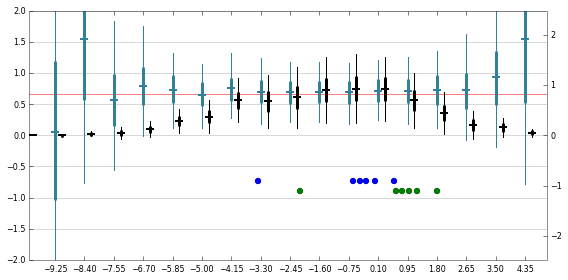

In [23]:
d1=np.median(w['dd'][:,0])
d2=DS[DS[:,0]==1,-2].mean()-DS[DS[:,0]==0,-2].mean()
plt.figure(figsize=(8,4))
plt.plot([-10,5],[d1,d1],'r',alpha=0.5)
res1=errorbar(ds.T,x=xs-0.1)
ax1=plt.gca()
plt.ylim([-2,2])
plt.xlim([-10,5])
plt.grid(b=False,axis='x')
ax2 = ax1.twinx()
res2=np.zeros((b.size,5))
for k in range(b.size):
    res2[k,:]=plotCIttest2(y1=P[k][0],y2=P[k][1],x=b[k]+0.1)
plt.ylim([-2/d1*d2,2/d1*d2])
plt.xlim([-10,5])
plt.grid(b=False,axis='y')
plt.plot(np.median(w['beta'],axis=0),[-0.9]*6,'ob')
plt.plot(np.median(w['beta']+np.atleast_2d(w['dd'][:,1]).T,axis=0),[-1.1]*6,'og')

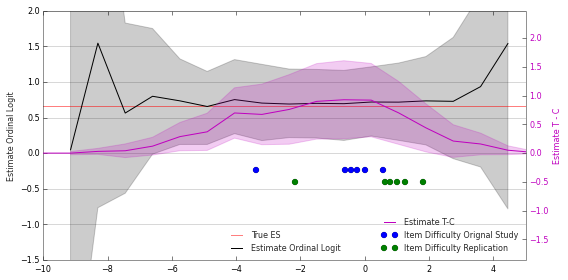

In [76]:
d1=np.median(w['dd'][:,0])
d2=DS[DS[:,0]==1,-2].mean()-DS[DS[:,0]==0,-2].mean()
plt.figure(figsize=(8,4))
ax1=plt.gca()
plt.plot([-10,5],[d1,d1],'r',alpha=0.5)
temp=[list(xs)+list(xs)[::-1],list(res1[:,1])+list(res1[:,2])[::-1]]
ax1.add_patch(plt.Polygon(xy=np.array(temp).T,alpha=0.2,fc='k',ec='k'))
plt.plot(xs,res1[:,0],'k')
plt.ylim([-1.5,2])
plt.xlim([-10,5])
plt.grid(b=False,axis='x')
plt.legend(['True ES','Estimate Ordinal Logit'],loc=8)
plt.ylabel('Estimate Ordinal Logit')
ax2 = ax1.twinx()
temp=[list(b)+list(b)[::-1],list(res2[:,1])+list(res2[:,2])[::-1]]
for t in range(len(temp[0]))[::-1]:
    if np.isnan(temp[1][t]):
        temp[0].pop(t);temp[1].pop(t)
ax2.add_patch(plt.Polygon(xy=np.array(temp).T,alpha=0.2,fc='m',ec='m'))
plt.plot(b,res2[:,0],'m')
plt.ylim([-1.5/d1*d2,2/d1*d2])
plt.xlim([-10,5])
plt.grid(b=False,axis='y')
plt.plot(np.median(w['beta'],axis=0),[-0.3]*6,'ob')
plt.plot(np.median(w['beta']+np.atleast_2d(w['dd'][:,1]).T,axis=0),[-0.5]*6,'og')
plt.legend(['Estimate T-C','Item Difficulty Orignal Study','Item Difficulty Replication'],loc=4)
plt.ylabel('Estimate T - C',color='m')
for tl in ax2.get_yticklabels():tl.set_color('m')